In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr #pip3 install --user finance-datareader
from fredapi import Fred
import datetime, os

import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np


In [2]:
#ticker='msft aapl goog'#'SPY'
tickers=['QQQ','GLD']
yf.pdr_override()
df_price = pdr.get_data_yahoo(tickers)
df_price.isnull().sum()
df_price.dropna(axis=0,inplace=True)

[*********************100%***********************]  2 of 2 completed


In [3]:
start = df_price.index[0] 
end   = df_price.index[-1]
df_new_index = pd.date_range(start,end)
df_price = df_price.reindex(df_new_index)

df_price.isna().sum()
df_price.replace(np.NaN, 0, inplace=True)
#df_price[0:3]

In [4]:
for today in df_price.index[1:]:
  for col in df_price.columns.values:
    if df_price[col][today] == 0:
      df_price[col][today] = df_price[col][today-datetime.timedelta(days=1)]

In [5]:
trading_df = pd.DataFrame(df_price['Close'])

etfs = np.array(trading_df.columns.values)[::-1]

trading_df[[etf+'_qty' for etf in etfs]]     = 0
trading_df[[etf+'_capital' for etf in etfs]] = 0
trading_df['Total'] = 0
#trading_df[0:3]

In [6]:
import datetime
from dateutil import relativedelta

def get_pivot(year, month, day):
  pivot_date = datetime.datetime.strptime("%d-%d-%d"%(year,month,day), "%Y-%m-%d")
  return pivot_date

def get_next_month(today:datetime):
    nextmonth = today + relativedelta.relativedelta(months=1)
    return nextmonth

def set_reblancing_date(trading_df, start_date, end_date):
  trading_df['Pivot'] = 0
  trading_df.loc[start_date,'Pivot'] = 1
  trading_df.loc[end_date,'Pivot'] = 1
  iter_date = start_date
  while iter_date < end_date:
    AW_4_  = (iter_date.month==4)
    AW_11_ = (iter_date.month==11)
    if (AW_4_ or AW_11_):
      pivot_date = get_pivot(iter_date.year,iter_date.month,28)
      trading_df.loc[pivot_date,'Pivot'] = 1 
    iter_date = get_next_month(iter_date)
  return trading_df

In [7]:
# Sim Env
# 2010-2011 & 2018-2019
start_date = '2018-10-30'
end_date   = '2018-12-31'
start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')
end_date   = datetime.datetime.strptime(end_date, '%Y-%m-%d')
period = (start_date <= trading_df.index) & (end_date >= trading_df.index)
trading_df = trading_df.loc[period]

init_capital = 1_000_000

trading_df = set_reblancing_date(trading_df,start_date, end_date)
trading_df[0:3]

,GLD,QQQ,QQQ_qty,GLD_qty,QQQ_capital,GLD_capital,Total,Pivot
2018-10-30,115.800003,165.919998,0,0,0,0,0,1
2018-10-31,115.150002,169.820007,0,0,0,0,0,0
2018-11-01,116.629997,172.059998,0,0,0,0,0,0


In [8]:
def buy_portpolio(trading_df, init_capital ,etfs):
  capital = init_capital
  ratios = [1, 0] 
  budgets = (np.ones(len(etfs))*capital)*ratios
  qtys   = (budgets/ trading_df.loc[trading_df.index[0],etfs].values).astype(int)

  for i, etf in enumerate(etfs):
    trading_df.loc[:, etf+'_qty'] = qtys[i] 
    trading_df[etf+'_capital'] = trading_df[etf+'_qty']*trading_df[etf]

  return trading_df

def init_result_columns(trading_df):
  capital = init_capital#trading_df['Total'].iloc[0]
  trading_df['Total'] = trading_df[[etf+'_capital' for etf in etfs]].sum(axis=1)
  trading_df['Yield'] = (trading_df['Total']-capital)/capital*100
  trading_df['MDD'] = 0
  return trading_df

trading_df = buy_portpolio(trading_df, init_capital, etfs)
trading_df = init_result_columns(trading_df)
not_reblance = trading_df.copy()
#trading_df[['QQQ_capital', 'GLD_capital']].plot()
#trading_df['Total'].plot()

[0 1 2 3 4]    val
0    6
1   13
2   15
3   21
4   25


KeyError: 0

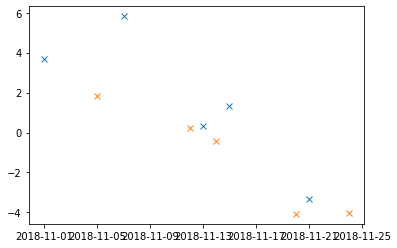

In [9]:
# Reblancing
index = trading_df.loc[trading_df['Pivot']==True,:].index.values

for i in range(len(index)-1):
  period = (index[i] <= trading_df.index) & (index[i+1] >= trading_df.index)
  quater_df = trading_df.loc[period,:].copy()
  if len(quater_df) == 0:
    break;

  quater_capital = 0
  for etf in etfs:
    quater_capital = quater_capital + quater_df.iloc[0].xs(etf+'_capital')
  quater_df = buy_portpolio(quater_df, quater_capital, etfs)
  quater_df = init_result_columns(quater_df)

  #peak
  peaks, _  = find_peaks(quater_df['Yield'])
  peaks2, _ = find_peaks(-quater_df['Yield'])
  plt.plot(quater_df.index[peaks],quater_df['Yield'][peaks],'x')
  plt.plot(quater_df.index[peaks2],quater_df['Yield'][peaks2],'x')

  def MDD(quater_df, peaks, peaks2):
    high_df =  pd.DataFrame(peaks, columns=['val'])
    low_df  = pd.DataFrame(peaks2, columns=['val'])
    capital_df = quater_df['Yield']

    for i in range(min(len(peaks),len(peaks2))-2):
      print(low_df.index.values, low_df)
      if capital_df[ high_df[i] ] < capital_df[high_df[i+1]]:
        high_df = high_df.drop(index=[i])
        low_df = low_df.drop(index=[i])
      else:
        if capital_df[ low_df[i] ] > capital_df[low_df[i+1]]:
          low_df = low_df.drop(index=[i])
      #else:
      #  low_df = low_df.drop(index=[i])


    peaks  = np.array(high_df.values).reshape(-1)
    peaks2 = np.array(low_df.values).reshape(-1)

    if 1:
      if len(peaks) == len(peaks2):
        diff = capital_df[peaks].values - capital_df[peaks2].values
        period = list(zip(peaks,peaks2))
      elif len(peaks) < len(peaks2):
        diff = capital_df[peaks].values - capital_df[peaks2[:len(peaks)]].values 
        period = list(zip(peaks,peaks2[:len(peaks)]))
      else:
        diff = capital_df[peaks[:len(peaks2)]].values - capital_df[peaks2].values 
        period = list(zip(peaks[:len(peaks2)],peaks2))
      period = list(map(lambda x: ((capital_df.index[x[0]]<=capital_df.index) & (capital_df.index< capital_df.index[x[1]])), period))

      for i,p in enumerate(period):
        quater_df.loc[p,'MDD'] = -diff[i]
    return quater_df


  quater_df = MDD(quater_df, peaks, peaks2)

  # MDD
  #maximum = quater_df['Yield'][quater_df['Yield'].idxmax()]
  #minimum = quater_df['Yield'].loc[  (quater_df['Yield'].idxmax()<=quater_df.index)].min()
  #quater_df['MDD'] = minimum-maximum

  #Save
  trading_df.loc[period,:] = quater_df


#trading_df['Total'].plot()      #else:
      #  low_df = low_df.drop(index=[i])
trading_df['MDD'].plot(label='Max Drawdown [%]')
plt.legend()


#plt.ylabel('[%]')

In [ ]:
#trading_df[['QQQ_capital', 'GLD_capital']].plot()
not_reblance['Total'].plot()
trading_df['Total'].plot()